# Breast cancer data analysis - v1
- https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

# Credit:

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve, validation_curve, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from xgboost.sklearn import XGBRegressor
from math import sqrt
from scipy import stats
import datetime
import sys
from inspect import getsourcefile
import os.path
import re
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# Input data files are available in the DATA_DIR directory.
DATA_DIR = "data-temp"

# Load data

In [4]:
# Load data. Download from:https://www.kaggle.com/sarahvch/breast-cancer-wisconsin-prognostic-data-set
train_data = pd.read_csv(DATA_DIR + "/data.csv")

In [5]:
train_data = train_data.iloc[:, :-1]
train_data.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Encode label value

In [6]:
label = 'diagnosis'
target = train_data[label]
target.head(5)

0    M
1    M
2    M
3    M
4    M
Name: diagnosis, dtype: object

In [7]:
data_dict = {'M':1, 'B':0}
target = target.map(data_dict)
target[:5]


0    1
1    1
2    1
3    1
4    1
Name: diagnosis, dtype: int64

In [14]:
train_set = train_data.drop(['id', label], axis=1)
train_set[:5]

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Exploring data

### Check null data

In [9]:
def check_null_data(data):
    #Get high percent of NaN data
    null_data = data.isnull()
    total = null_data.sum().sort_values(ascending=False)
    percent = (null_data.sum()/null_data.count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    high_percent_miss_data = missing_data[missing_data['Percent']>0]
    #print(missing_data)
    print(high_percent_miss_data)
    miss_data_cols = high_percent_miss_data.index.values
    return miss_data_cols

In [10]:
check_null_data(train_data)

Empty DataFrame
Columns: [Total, Percent]
Index: []


array([], dtype=object)

In [11]:
train_set.dtypes

radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst       float64
symmetry_worst      

# Train model

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(train_set, target, train_size=0.7, random_state=324)
print("train size:", X_train.shape, " test size:", X_test.shape)

train size: (398, 30)  test size: (171, 30)


In [44]:
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [57]:
coef = model.coef_
intercept = model.intercept_
ex1 = np.linspace(0, 40, 10)
print('intercept:', intercept.shape)
print('coef:', coef.shape)
temp = coef[:, 0] * ex1 + intercept
ex2 = -(coef[:, 0] * ex1 + intercept) / coef[:,1]
ex2

intercept: (1,)
coef: (1, 30)


array([  -4.77125095, -103.72727704, -202.68330313, -301.63932922,
       -400.59535531, -499.5513814 , -598.50740749, -697.46343358,
       -796.41945967, -895.37548576])

In [62]:
y_pred = model.predict(X_test)
print(model.score(X_test, Y_test))

0.941520467836


### Plot decision boundary

In [63]:
def map_features(f1, f2, order=1):
    '''map the f1 and f2 to its higher order polynomial'''
    assert order >= 1
    def iter():
        for i in range(1, order + 1):
            for j in range(i + 1):
                yield np.power(f1, i - j) * np.power(f2, j)
    return np.vstack(iter())

(20, 158404)


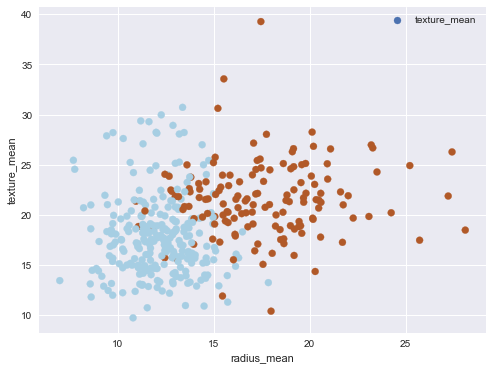

In [73]:
x_label = 'radius_mean'
y_label = 'texture_mean'
x_data = X_train[x_label]
y_data = X_train[y_label]

plt.figure(1, figsize=(8, 6))
# Plot also the training points
plt.scatter(x_data, y_data, c=Y_train, cmap=plt.cm.Paired)
plt.xlabel(x_label)
plt.ylabel(y_label)
#plot decision boundary
# see the coutour approach for a more general solution
ex1 = np.linspace(x_data.min(), x_data.max(), len(x_data))
#ex2 = -(coef[:, 0] * ex1 + intercept) / coef[:,1]
#plt.plot(ex1, ex2, color='r', label='decision boundary');
dx, dy = np.meshgrid(ex1, ex1)
v = map_features(dx.flatten(), dy.flatten(), order=5)
print(v.shape)
#z1 = np.dot(coef, v) + intercept
#z = (np.dot(coef, v) + intercept).reshape(len(x_data), len(x_data))
#plt.contour(dx, dy, z, levels=[0], colors=['r'])

plt.legend();
plt.show()